In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
from tensorflow.python.ops import array_ops as array_ops_
import matplotlib.pyplot as plt
learn = tf.contrib.learn

#### 1. 设置神经网络的参数。

In [2]:
HIDDEN_SIZE = 30
NUM_LAYERS = 2

TIMESTEPS = 10
TRAINING_STEPS = 3000
BATCH_SIZE = 32

TRAINING_EXAMPLES = 10000
TESTING_EXAMPLES = 1000
SAMPLE_GAP = 0.01

#### 2. 定义生成正弦数据的函数。

In [3]:
def generate_data(seq):
    X = []
    y = []

    for i in range(len(seq) - TIMESTEPS - 1):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

#### 3. 定义lstm模型。

In [4]:
def lstm_model(X, y):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE, state_is_tuple=True)
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell] * NUM_LAYERS)
    
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])
    
    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构。
    predictions = tf.contrib.layers.fully_connected(output, 1, None)
    
    # 将predictions和labels调整统一的shape
    labels = tf.reshape(y, [-1])
    predictions=tf.reshape(predictions, [-1])
    
    loss = tf.losses.mean_squared_error(predictions, labels)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)

    return predictions, loss, train_op

#### 4. 进行训练。

In [5]:
# 封装之前定义的lstm。
regressor = SKCompat(learn.Estimator(model_fn=lstm_model,model_dir="Models/model_2"))

# 生成数据。
test_start = TRAINING_EXAMPLES * SAMPLE_GAP
test_end = (TRAINING_EXAMPLES + TESTING_EXAMPLES) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES, dtype=np.float32)))

# 拟合数据。
regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

# 计算预测值。
predicted = [[pred] for pred in regressor.predict(test_X)]

# 计算MSE。
rmse = np.sqrt(((predicted - test_y) ** 2).mean(axis=0))
print ("Mean Square Error is: %f" % rmse[0])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11a5590d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into Models/model_2/model.ckpt.
INFO:tensorflow:loss = 0.491647, step = 1
INFO:tensorflow:global_step/sec: 188.742
INFO:tensorflow:loss = 0.00536189, step = 101
INFO:tensorflow:global_step/sec: 232.293
INFO:tensorflow:loss = 0.00523746, step = 201
INFO:tensorflow:global_step/sec: 222.852
INFO:tensorflow:loss = 0.00308377, step = 301
INFO:tensorflow:global

#### 5. 画出预测值和真实值的曲线。

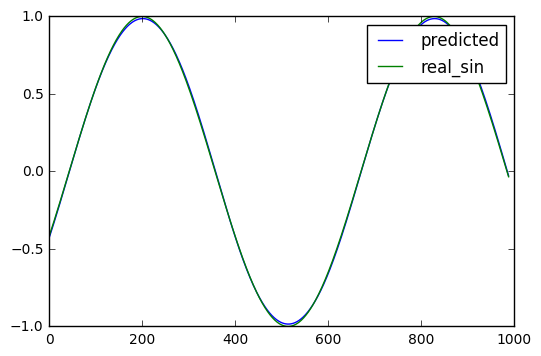

In [6]:
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(test_y, label='real_sin')
plt.legend([plot_predicted, plot_test],['predicted', 'real_sin'])
plt.show()